# Check Online Phase for PBDW and TR-GEIM
This notebook takes the Snapshots, and check the reconstruction for perfect measurements for PBDW and TR-GEIM.

Let us create the mesh from the OpenFOAM nodes and cells

In [ ]:
from pyforce.tools.write_read import ReadFromOF
from IPython.display import clear_output as clc

from matplotlib import cm, rcParams, pyplot as plt
import pickle

path_snaps = '../../../Data/MSFR/'
of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('../ReflectorSensing/Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('../ReflectorSensing/Results/times.npz')['fom_times']

measured_filed = [0]
var_names = [var_names[i] for i in measured_filed]
is_vector = [is_vector[i] for i in measured_filed]

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('../ReflectorSensing/Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.25, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

test_snaps = dict()

for field_i, field in enumerate(var_names):
    test_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in test_indices:
        test_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

Let us load the magic functions and sensors

In [4]:
from pyforce.tools.write_read import ImportH5

strategy = 'ID'

magic_fun = dict()
magic_sen = dict()

for field_i, field in enumerate(var_names):
    magic_fun[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_mf',
                                f'GEIM_{field}_{strategy}_mf')[0]
    magic_sen[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_ms',
                                f'GEIM_{field}_{strategy}_ms')[0]

Let us load the GEIM training coefficients

In [5]:
training_betas = {field: np.load(f'Results/GEIM_offline/GEIM_{field}_{strategy}_TrainBeta.npz')['arr_0']
                  for field in var_names}

mean_beta = {field: np.mean(training_betas[field], axis=0)
                for field in var_names}
std_beta = {field: np.std(training_betas[field], axis=0)
                for field in var_names}

Let us load the POD modes and the SGREEDY sensors

In [6]:
pod_modes = dict()
sgreedy_sens = dict()

for field_i, field in enumerate(var_names):
    pod_modes[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/POD_{field}_modes',
                                f'POD_{field}_modes')[0]
    sgreedy_sens[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/SGREEDY_{field}_sensors',
                                   f'SGREEDY_{field}_sensors')[0]

Let us set the noise level

In [7]:
noise_level = 1e-3

## TR-GEIM Online
The Tikhonov regularization for the Generalized Empirical Interpolation Method (TR-GEIM) is used to reconstruct the snapshots.

In [8]:
from pyforce.online.tr_geim import TRGEIM

trgeim_online = {
    field: TRGEIM(magic_fun[field], magic_sen[field], name=field,
                  mean_beta=mean_beta[field], std_beta=std_beta[field])

    for field in var_names
}

Let us check the synthetic error

In [9]:
geim_rel_err = dict()

for field in var_names:
    geim_rel_err[field] = trgeim_online[field].synt_test_error(test_snaps[field], noise_level, noise_level**2,
                                                               M=15, verbose=True)[1]

Computing TR-GEIM test error (synthetic) - T: 69.000 / 69.00 - 0.330 s/it


## PBDW Online
The Parameterised-Background Data-Weak (PBDW) method is used to reconstruct the snapshots.

In [10]:
from pyforce.online.pbdw import PBDW

pbdw_online = {
    field: PBDW(pod_modes[field], sgreedy_sens[field], name=field)
    for field in var_names
}

Let us check the synthetic error

In [18]:
pbdw_rel_err = dict()
for field in var_names:
    pbdw_rel_err[field] = pbdw_online[field].synt_test_error(test_snaps[field], N=5, M=15, reg_param=100,
                                                             noise_value=noise_level, verbose=True)[1]

Computing PBDW test error (synthetic) with N = 5 - T: 69.000 / 69.00 - 0.294 s/it


## Error comparison

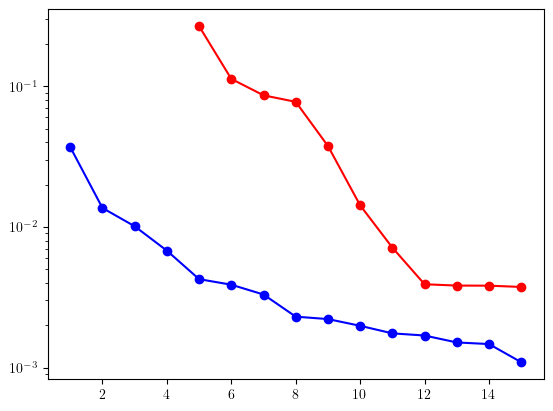

In [20]:
geim_Mplot = np.arange(1, 16)
pbdw_Mplot = np.arange(5, 16)

plt.semilogy(geim_Mplot, geim_rel_err[var_names[0]], 'bo-', label='GEIM')
plt.plot(pbdw_Mplot, pbdw_rel_err[var_names[0]], 'ro-', label='PBDW')

Let us compare the reconstruction with some plots

In [16]:
trgeim_recons = {
    field: [trgeim_online[field].reconstruct(test_snaps[field](tt), M=15, noise_value=noise_level, reg_param=noise_level**2)[0]
            for tt in range(len(test_snaps[field]))]
    for field in var_names
}

pbdw_recons = {
    field: [pbdw_online[field].reconstruct(test_snaps[field](tt), N=5, M=15, reg_param=10, noise_value=noise_level)[0]
            for tt in range(len(test_snaps[field]))]
    for field in var_names
}

Let us make a contour plot of the reconstructed field

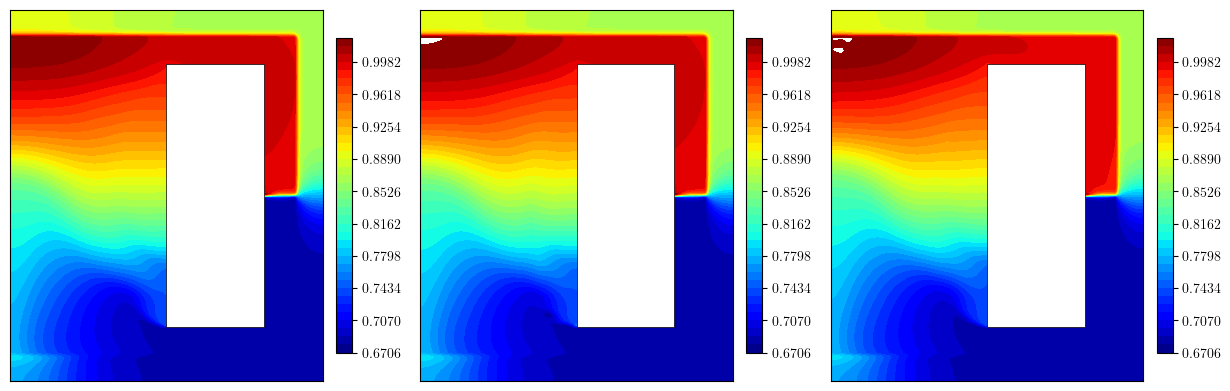

In [17]:
from utils import plot_contour

mesh_plot = np.concatenate((domain.geometry.x[:, 0].reshape(-1,1), domain.geometry.x[:, 2].reshape(-1,1)), axis=1)

cmap = cm.jet

field_i = 0
field = var_names[field_i]

levels = np.linspace(test_snaps[field].return_matrix().min(),
                   test_snaps[field].return_matrix().max(), 40)

sampling = 5
for tt in range(sampling-1, len(test_snaps[field]), sampling):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))

    cont = plot_contour(axs[0], mesh_plot, test_snaps[field](tt), cmap=cmap, levels=levels)
    plot_contour(axs[1], mesh_plot, trgeim_recons[field][tt], cmap=cmap, levels=levels)
    plot_contour(axs[2], mesh_plot, pbdw_recons[field][tt], cmap=cmap, levels=levels)

    for ax in axs:
        fig.colorbar(cont, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    plt.show()
    clc(wait=True)
    plt.close(fig)